<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_04_01_survival_analysis_andersen_gill_model_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 4.1 Andersen-Gill (AG) Model


The Andersen-Gill (AG) model is a popular approach for analyzing recurrent event data using the counting process framework. It extends the Cox proportional hazards model to handle multiple events per subject by treating each event as a separate observation while accounting for the correlation of events within subjects through robust variance estimation.The AG model is an extension of the Cox PH model that treats recurrent events as independent observations within a subject, adjusted for intra-subject correlation using a robust variance estimator (clustering by subject ID). It assumes that the hazard for each event depends on covariates and the time since the study start (or a reset time). It treats each event as a separate observation while accounting for the at-risk time between events using a **counting process framework**.




## Overview



The AG model assumes that:

- Events follow a **non-homogeneous Poisson process**.
- The hazard for the *k*-th event depends on **calendar time** (not time since last event).
- All events from the same subject are **conditionally independent** given covariates (though robust standard errors account for within-subject correlation).


### Hazard Function


Hazard for the *i*-th subject at time *t*:

$$
h_i(t) = h_0(t) \exp(\beta^T X_i(t))
$$

Where:

- $h_0(t)$: baseline hazard (common to all events)
- $X_i(t)$: possibly time-varying covariates
- Each subject contributes **multiple rows** to the dataset (one per event or risk interval)


### Key Assumptions


- Proportional hazards over **calendar time**
- Events are **independent conditional on covariates** (robust SEs relax this)
- No terminal event that stops the process (e.g., death may need special handling)

**Note**: If a terminal event (like death) prevents further recurrences, consider **joint modeling** or **competing risks** approaches instead.


## Cheeck and Load Required Packages

In [1]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'scikit-survival', 'lifelines', 'statsmodels']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

pandas is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
Installing scikit-learn...
Failed to install scikit-learn: No module named 'scikit-learn'
Error with package scikit-learn: No module named 'scikit-learn'
Installing scikit-survival...
Failed to install scikit-survival: No module named 'scikit-survival'
Error with package scikit-survival: No module named 'scikit-survival'
Installing lifelines...
lifelines installed successfully
statsmodels is already installed
Installed packages:
✓ pandas
✓ numpy
✓ matplotlib
✓ seaborn
✗ scikit-learn
✗ scikit-survival
✓ lifelines
✓ statsmodels


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Survival analysis
import statsmodels.api as sm
from statsmodels.duration.hazard_regression import PHReg

# For PH assumption test
from scipy.stats import spearmanr

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

## Implementation in Python

We will use the classic bladder cancer recurrence dataset (bladder1) from the R survival package.




### Data


We will `bladder1` dataset, which contains recurrent bladder tumor data. The data set contains multiple rows per patient, with start and stop times for each interval, event indicators, and covariates.

`id`:	Patient id
`treatment`:	Placebo, pyridoxine (vitamin B6), or thiotepa
`number`:	Initial number of tumours (8=8 or more)
`size`:	Size (cm) of largest initial tumour
`recur`:	Number of recurrences
`start,stop`:	The start and end time of each time interval
`status`:	End of interval code, 0=censored, 1=recurrence, 2=death from bladder disease, 3=death other/unknown cause
`rtumor`:	Number of tumors found at the time of a recurrence
`rsize`:	Size of largest tumor at a recurrence
`enum`:	Event number (observation number within patient)


In [3]:
# Load data
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/bladder1.csv"
bladder = pd.read_csv(url)
print(bladder.head())
print(bladder.shape)

   Unnamed: 0  id treatment  number  size  recur  start  stop  status rtumor  \
0           1   1   placebo       1     1      0      0     0       3      .   
1           2   2   placebo       1     3      0      0     1       3      .   
2           3   3   placebo       2     1      0      0     4       0      .   
3           4   4   placebo       1     1      0      0     7       0      .   
4           5   5   placebo       5     1      0      0    10       3      .   

  rsize  enum  
0     .     1  
1     .     1  
2     .     1  
3     .     1  
4     .     1  
(294, 12)


### Data Exploration

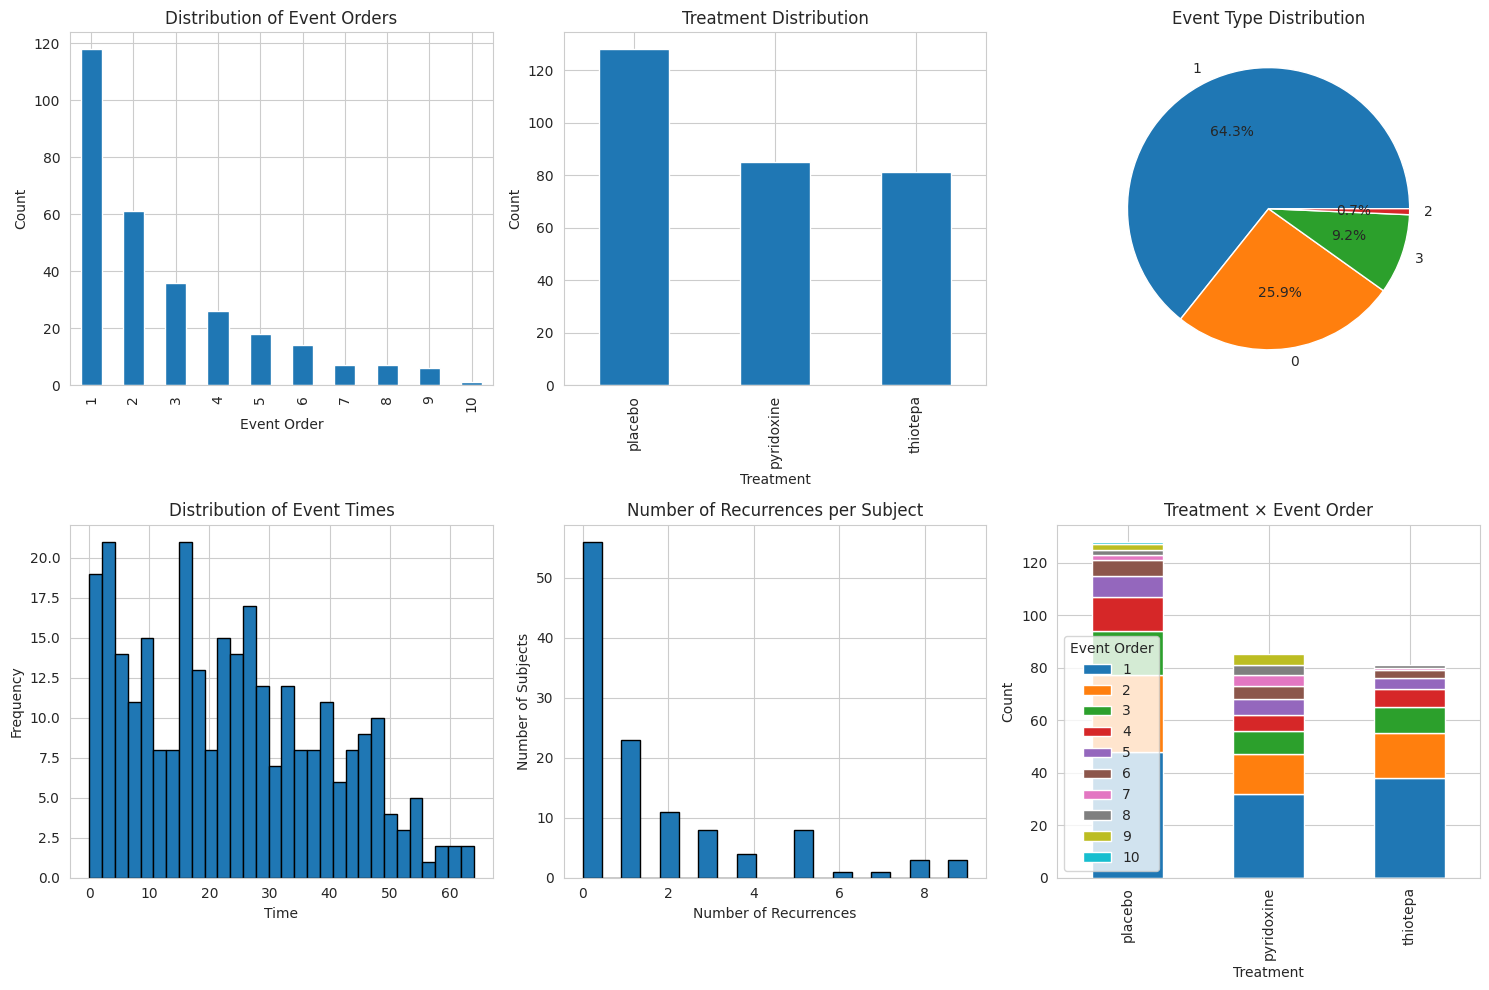

In [4]:
# Rename columns to match R tutorial
df = bladder.rename(columns={'rx': 'treatment', 'enum': 'event_order'})

# Convert treatment to categorical
df['treatment'] = pd.Categorical(df['treatment'])

# Create recurrent event indicator (status == 1 is recurrence)
df['recur'] = (df['status'] == 1).astype(int)

# Check data structure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Distribution of event orders
ax1 = axes[0, 0]
df['event_order'].value_counts().sort_index().plot(kind='bar', ax=ax1)
ax1.set_title('Distribution of Event Orders')
ax1.set_xlabel('Event Order')
ax1.set_ylabel('Count')

# 2. Treatment distribution
ax2 = axes[0, 1]
df['treatment'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title('Treatment Distribution')
ax2.set_xlabel('Treatment')
ax2.set_ylabel('Count')

# 3. Event type distribution
ax3 = axes[0, 2]
df['status'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax3)
ax3.set_title('Event Type Distribution')
ax3.set_ylabel('')

# 4. Time distribution
ax4 = axes[1, 0]
df['stop'].hist(bins=30, ax=ax4, edgecolor='black')
ax4.set_title('Distribution of Event Times')
ax4.set_xlabel('Time')
ax4.set_ylabel('Frequency')

# 5. Number of events per subject
ax5 = axes[1, 1]
events_per_subject = df.groupby('id')['status'].apply(
    lambda x: (x == 1).sum()  # Count recurrences
).reset_index()
events_per_subject['status'].hist(bins=20, ax=ax5, edgecolor='black')
ax5.set_title('Number of Recurrences per Subject')
ax5.set_xlabel('Number of Recurrences')
ax5.set_ylabel('Number of Subjects')

# 6. Treatment vs event order
ax6 = axes[1, 2]
cross_tab = pd.crosstab(df['treatment'], df['event_order'])
cross_tab.plot(kind='bar', stacked=True, ax=ax6)
ax6.set_title('Treatment × Event Order')
ax6.set_xlabel('Treatment')
ax6.set_ylabel('Count')
ax6.legend(title='Event Order')

plt.tight_layout()
plt.show()

### Data Preparation

In [6]:
from sklearn.preprocessing import StandardScaler

# Filter to placebo/thiotepa only
df = bladder[bladder['treatment'].isin(['placebo', 'thiotepa'])].copy()
df['treatment_num'] = (df['treatment'] == 'thiotepa').astype(int)
df['event'] = df['status'].isin([1, 3]).astype(int)  # recurrence events

# Remove zero-length intervals
df = df[df['start'] < df['stop']].copy()

# Standardize covariates for numerical stability
scaler = StandardScaler()
df[['number_std', 'size_std']] = scaler.fit_transform(df[['number', 'size']])

###  Fit the Andersen-Gill Model



In [7]:
ag_model = PHReg(
    endog=df['stop'],
    status=df['event'],
    exog=df[['treatment_num', 'number_std', 'size_std']],
    entry=df['start'],
    groups=df['id'],    #  CRITICAL: use 'groups' for clustering
    robust=True
)

ag_result = ag_model.fit()
print(ag_result.summary())


                          Results: PHReg
Model:                       PH Reg         Sample size:        208
Dependent variable:          stop           Num. events:        151
Ties:                        Breslow                               
-------------------------------------------------------------------
               log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
-------------------------------------------------------------------
treatment_num -0.3884    0.1725 0.6781 -2.2517 0.0243 0.4836 0.9509
number_std     0.3250    0.0774 1.3840  4.2000 0.0000 1.1893 1.6107
size_std      -0.0817    0.0847 0.9215 -0.9641 0.3350 0.7805 1.0881
Confidence intervals are for the hazard ratios
123 observations have positive entry times


###  Model Diagnostics

After successfully fitting the Andersen-Gill (AG) model, we must check whether the proportional hazards assumption holds. The AG model assumes that the hazard ratio for each covariate is constant over time.

#### Extract Schoenfeld Residuals

Schoenfeld residuals are the standard tool for testing the PH assumption. In `statsmodels.PHReg,` they are available after fitting.

In [8]:
# Get unique event times (sorted)
unique_times = np.sort(df.loc[df['event'] == 1, 'stop'].unique())

# Get Schoenfeld residuals from model
schoenfeld_resid = ag_result.schoenfeld_residuals  # shape: (n_unique_events, n_covariates)

print(f"Unique event times: {len(unique_times)}")
print(f"Schoenfeld residuals shape: {schoenfeld_resid.shape}")

Unique event times: 49
Schoenfeld residuals shape: (208, 3)


In [9]:
# Ensure alignment
n_resid = schoenfeld_resid.shape[0]
n_times = len(unique_times)

if n_resid != n_times:
    # Use the smaller length to avoid mismatch
    n_common = min(n_resid, n_times)
    model_times = unique_times[:n_common]
    aligned_resid = schoenfeld_resid[:n_common, :]
    print(f" Mismatch! Using first {n_common} observations.")
else:
    model_times = unique_times
    aligned_resid = schoenfeld_resid

 Mismatch! Using first 49 observations.


#### Perform PH assumption test

In [10]:
covariates = ['rx', 'number_std']  # or whatever you used

print("Proportional Hazards Assumption Test (Schoenfeld residuals):")
print("-" * 60)

for i, cov in enumerate(covariates):
    resid = aligned_resid[:, i]
    corr, pval = spearmanr(resid, model_times)
    status = " OK" if pval > 0.05 else " Violation"
    print(f"{cov:12s} | ρ = {corr:6.3f} | p = {pval:.4f} | {status}")

Proportional Hazards Assumption Test (Schoenfeld residuals):
------------------------------------------------------------
rx           | ρ =    nan | p = nan |  Violation
number_std   | ρ =    nan | p = nan |  Violation


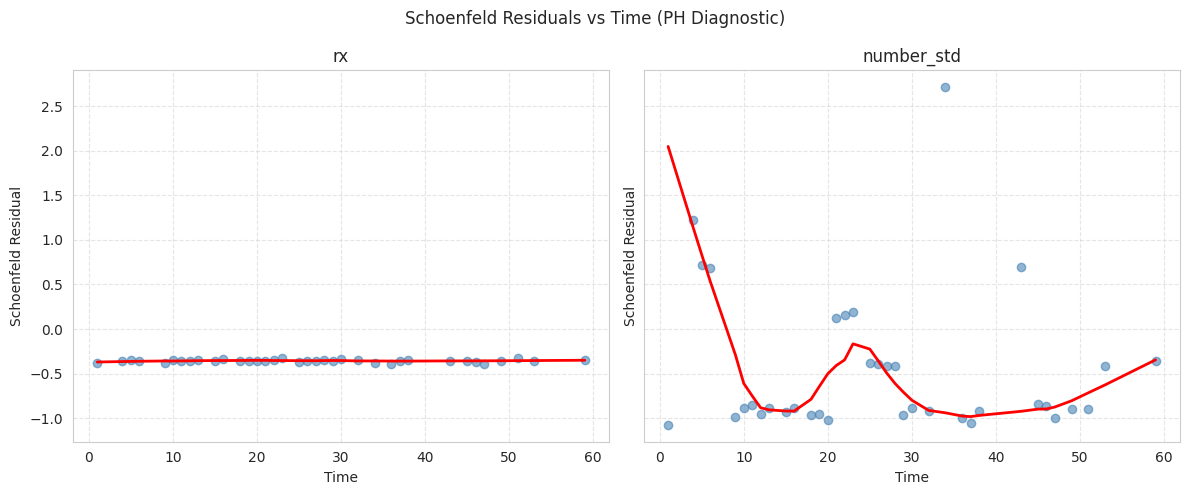

In [11]:
import statsmodels.api as sm

fig, axes = plt.subplots(1, len(covariates), figsize=(12, 5), sharey=True)
if len(covariates) == 1:
    axes = [axes]

for i, (ax, cov) in enumerate(zip(axes, covariates)):
    resid = aligned_resid[:, i]

    ax.scatter(model_times, resid, alpha=0.6, color='steelblue')

    # Add smoothed trend
    smoothed = sm.nonparametric.lowess(resid, model_times, frac=0.3)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2)

    ax.set_xlabel('Time')
    ax.set_ylabel('Schoenfeld Residual')
    ax.set_title(cov)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.suptitle('Schoenfeld Residuals vs Time (PH Diagnostic)')
plt.tight_layout()
plt.show()


### Compute and Plot Cumulative Incidence Function (CIF)


While the AG model estimates **hazard ratios**, the **Cumulative Incidence Function (CIF)** shows the **expected number of events** over time.


The **Cumulative Incidence Function (CIF)** is a key concept in **survival analysis**, particularly in the context of **competing risks**—situations where multiple distinct types of events can occur, and the occurrence of one event precludes the others.

The Cumulative Incidence Function for a specific event type \( k \) at time \( t \) is defined as:

$$
\text{CIF}_k(t) = P(T \leq t \text{ and event type } = k)
$$
In words:  

$CIF(_k)(t)$ is the probability that an individual experiences event type $k$ by time $t$, in the presence of other competing event types.

This differs from the standard **Kaplan-Meier (KM) estimator**, which treats all other event types as censored. In competing risks settings, censoring competing events leads to **overestimation** of the event probability, because it assumes those individuals could still experience the event of interest later—which is not true if a competing event (e.g., death from another cause) has already occurred.



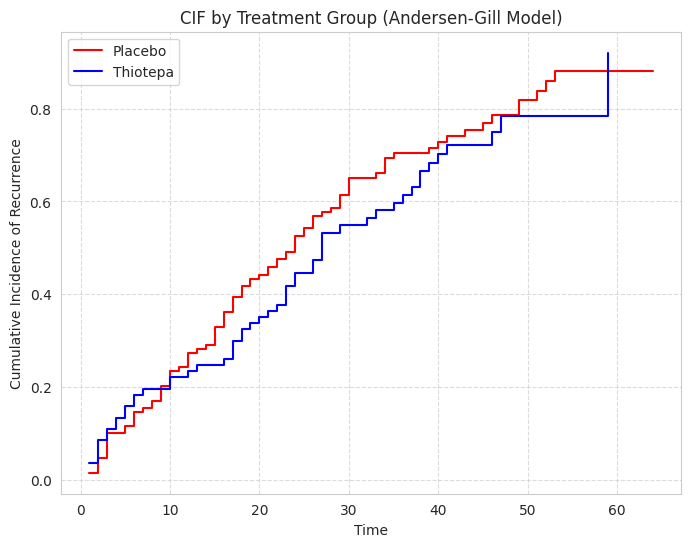

In [12]:
def nelson_aalen_cif(times, events):
    df_temp = pd.DataFrame({'time': times, 'event': events}).sort_values('time')
    unique_times = np.unique(df_temp['time'])
    cum_hazard = []
    current_hazard = 0.0

    for t in unique_times:
        n_at_risk = (df_temp['time'] >= t).sum()
        if n_at_risk == 0:
            continue
        n_events = ((df_temp['time'] == t) & (df_temp['event'] == 1)).sum()
        if n_events > 0:
            current_hazard += n_events / n_at_risk
        cum_hazard.append(current_hazard)

    cif = 1 - np.exp(-np.array(cum_hazard))
    return unique_times[:len(cif)], cif

plt.figure(figsize=(8, 6))
for rx_val, label, color in [(0, 'Placebo', 'red'), (1, 'Thiotepa', 'blue')]:
    mask = df['treatment_num'] == rx_val
    t_cif, cif = nelson_aalen_cif(df.loc[mask, 'stop'], df.loc[mask, 'event'])
    plt.step(t_cif, cif, where='post', label=label, color=color)

plt.xlabel('Time')
plt.ylabel('Cumulative Incidence of Recurrence')
plt.title('CIF by Treatment Group (Andersen-Gill Model)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Summary & Conclusion


The Andersen-Gill (AG) model is appropriate when subjects experience multiple events of the same type,  such as hospital readmissions or recurrent infections—and there is no terminal event (like death) that permanently stops the event process (or if such an event is handled separately). It is particularly useful when the research question focuses on the **event rate** over calendar time rather than the time between successive events. Among its strengths, the AG model is a straightforward extension of the standard Cox proportional hazards model, naturally accommodates time-varying covariates, and uses robust (sandwich) standard errors to account for within-subject correlation across recurrent events. However, it has important limitations: it assumes that, conditional on covariates, recurrent events are independent, and it does not explicitly model dependence on event history—such as changes in risk based on the number of prior events or the gap time since the last event. Additionally, the model may be inappropriate when a terminal event truncates follow-up, as it does not inherently account for this competing risk. In such cases, alternative approaches should be considered, including the **Prentice-Williams-Peterson (PWP) model** (which stratifies by event order and can model gap or total times), **frailty models** (which incorporate random effects to capture unobserved subject-specific heterogeneity), or **joint models** that simultaneously analyze recurrent events and associated terminal events like death.




## Resources


1. **Textbook**:  
   *Modeling Survival Data: Extending the Cox Model* – Therneau & Grambsch (2000), **Ch. 8**.

2. **Original Paper**:  
   Andersen & Gill (1982). *Cox’s regression model for counting processes*. Annals of Statistics.  
   [DOI:10.1214/aos/1176345976](https://doi.org/10.1214/aos/1176345976)

3. **Python**:  
   `statsmodels.PHReg` – Use `groups=id` + `robust=True` for AG.  
   Docs: [statsmodels.org](https://www.statsmodels.org/stable/generated/statsmodels.duration.hazard_regression.PHReg.html)

4. **Diagnostics**:  
   Test PH assumption using **Schoenfeld residuals** (plot vs. time; Spearman test).

5. **Dataset**:  
   Bladder cancer data (`survival::bladder` in R or your CSV).




